In [2]:
%cd '~/marker_identification/descrimination_evaluation'

/home/jmainguy/MIAT/Documents/marker_identification/descrimination_evaluation


In [178]:
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt, ceil
import matplotlib.gridspec as gridspec
import logging
import graph_display

In [64]:
# Set the logging level. When the flag verbose is defined to true
# logging are displayed from level info
verbose = False
if verbose:
    logging.basicConfig(format="%(levelname)s: %(message)s", level=logging.DEBUG)
    logging.info("Verbose output.")
else:
    logging.basicConfig(format="%(levelname)s: %(message)s")

nb sub graph 72
rows 8 cols 9


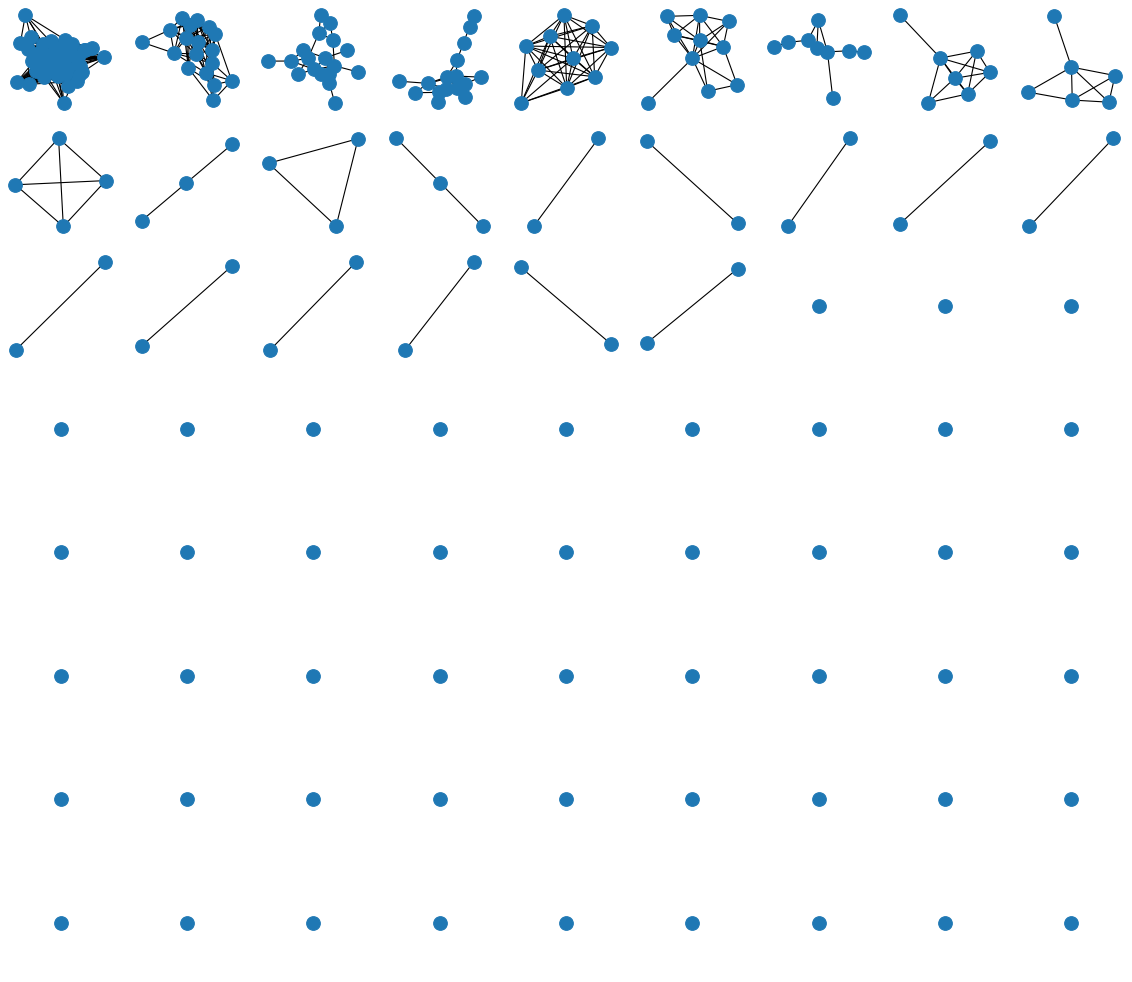

In [154]:
def count_sub_graph(G):
    return len(list(nx.connected_components(G)))
def get_value_to_scale(max_nb_nodes, max_size):
    return max_nb_nodes/max_size
    
    
def display_sub_graphs(G):
    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    sub_graphs = sorted(list(nx.connected_components(G)),key=len, reverse=True)
    
    nb_sub_graph = len(sub_graphs)
    nb_rows = int(sqrt(nb_sub_graph))
    nb_cols = int(nb_sub_graph/nb_rows)
    print('nb sub graph',nb_sub_graph )
    print('rows', nb_rows, 'cols', nb_cols)
    
    gridspec.GridSpec(nb_rows,nb_cols)
    for i, sub_graph_nodes in enumerate(sub_graphs):
        sub_graph = nx.subgraph(G, sub_graph_nodes)
        
        row_i = int(i/nb_cols)
        col_i = i % nb_cols
        plt.subplot2grid((nb_rows,nb_cols), (row_i,col_i))
        
        nx.draw_spring(sub_graph, node_size =150)
    
display_sub_graphs(G)

INFO: scalling_value (0.58) = max_nb_nodes (58)/ max_square_size (100)


nb of singleton 48


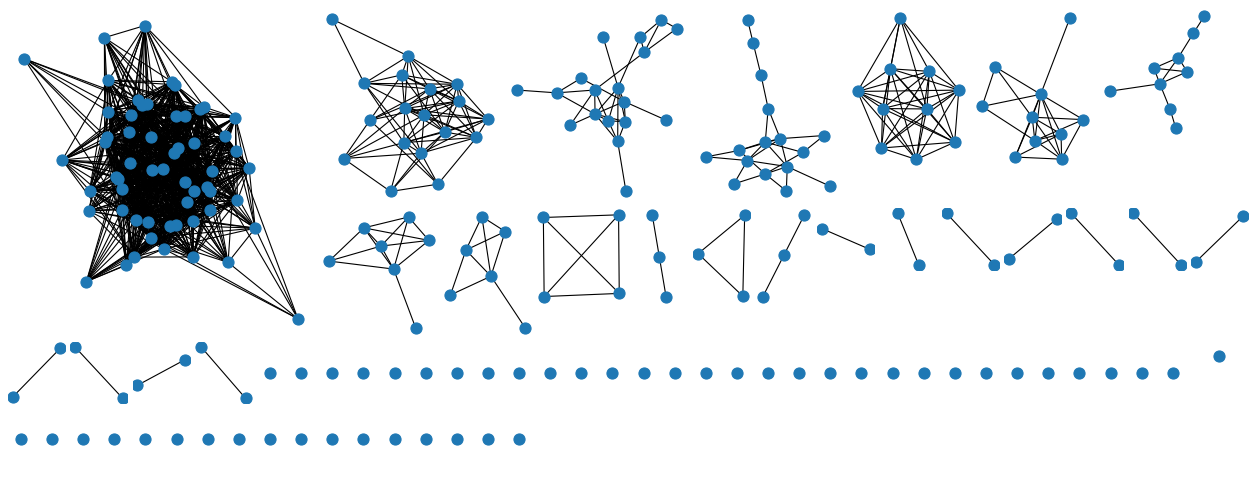

In [177]:
def get_sub_graph_location(sub_graph_size, remaining_spaces, edgings, min_ratio):
    """
    Equations: 
            
    min_length * max_length = sub_graph_size 
    
    min_length/max_length >= min_ratio 
    
    Finally:
    min_len >= srqt(sub_graph_size*min_ratio)
    max_len <= srqt(sub_graph_size/min_ratio)
    """
    # print( '    ' ,'<-->'*10)
    for s in sorted(remaining_spaces, key=lambda k: k['row']):
        pass
        # print('   ', s)
    # print( '    ' ,'<-->'*10)
    
    
    remove_last_space = False
    min_side_ss_graph = ceil(sqrt(sub_graph_size * min_ratio))
    max_side_ss_graph = ceil(sub_graph_size/min_side_ss_graph) 
                
    # print(f'  Graph size={ sub_graph_size}')
    
    for space in sorted(remaining_spaces, key=lambda k: k['row']) :
        h = space['h']
        w = space['w']
        # print(f'    ({space["row"]}, {space["col"]}), h={h}, w={w}, w*h={w*h}')
        # print(f'    min space side ({min([h,w])}) should be bigger than sqrt(sub_graph_size * min_ratio) ({sqrt(sub_graph_size * min_ratio)})')
        
        # min space side >= min allowed ss graph side
        if h*w >= sub_graph_size and min([h,w]) >= min_side_ss_graph: 
            # The space is big enough for the sub_graph
            # print('    SPACE ENOUGH')
            remove_last_space = True 
            break
        else:
            # print('    NO SPACE')
            # check next space
            pass
        
    if remove_last_space:
        compatible_space = space
        remaining_spaces.remove(space)
        
    else:
        # create a space of height of the sub graph and with maximum width 
        # This space will be used by the sub graph 
        # and what remain will be added to remaining space list
        compatible_space = {'row':edgings['row'], 
                            "col":0 , 
                            'w':edgings['col'], 
                            'h':edgings['row'] + min_side_ss_graph}
        
        # new edging row is defined
        edgings['row'] += edgings['row'] + min_side_ss_graph
        
    # Let's define location of the subgraph  
    graph_row = compatible_space['row']
    graph_col = compatible_space['col']
                
    if compatible_space['w'] > ceil(sqrt(sub_graph_size/min_ratio)): # meaning if space width > max_length 
        # prioritize big w over big h but still in respect of the ratio
        graph_w = max_side_ss_graph
    else:
        # side w is equal or lower than max len 
        # then of side w is allocated to the subgraph
        graph_w = compatible_space['w']
    
    # we know the width now let's calculate the corresponding h
    graph_h = ceil(sub_graph_size/graph_w)
                
    graph_location = {'row':graph_row, "col":graph_col , 'w':graph_w, 'h':graph_h}
    
    
    # define the new remaining spaces and add it to the remaining space list.
    # print("  graph_row", graph_row, "graph_h", graph_h, "edgings[row]", edgings['row'])
    if graph_h < compatible_space['h']:
        # An empty space exists between the created subgraph and the edging row of the space
        # Let's characterize it
        # print('     new space on the edging row ')
        new_space_row = graph_row +  graph_h
        new_space_col = graph_col
        # redefinded 
        new_space_h =  compatible_space['row']  + compatible_space['h'] - new_space_row
        new_space_w = compatible_space['col'] + compatible_space['w']  - new_space_col
        
        new_space = {'row':new_space_row, "col":new_space_col , 'w':new_space_w, 'h':new_space_h}
                
        if new_space not in remaining_spaces:
        
            remaining_spaces.append(new_space)
        else:
            # print('AAAA, SPACE ALREADY FOUND ! ')
            raise
        # print(f"    {new_space}")
        
    # print("  graph_col", graph_col, "graph_w", graph_w, "edgings['col']", edgings['col'])
    if graph_w < compatible_space['w']:
        # An empty space exists between the created subgraph and the edging col of the compatible space
        # Let's characterize it
        # print('    new space on the edging col ')
        new_space_row = graph_row
        new_space_col = graph_col + graph_w
        new_space_h =  compatible_space['row']  + graph_h - new_space_row
        new_space_w = compatible_space['col'] + compatible_space['w']  - new_space_col
        
        new_space = {'row':new_space_row, "col":new_space_col , 'w':new_space_w, 'h':new_space_h}
        # print(f"    {new_space}")
        if new_space not in remaining_spaces:
            remaining_spaces.append(new_space)
        else:
            # print('AAAA, SPACE ALREADY FOUND ! ')
            raise 
        
    return graph_row, graph_col, graph_w, graph_h


def display_sub_graphs_proportionally(G):
    
    sub_graphs = sorted(list(nx.connected_components(G)),key=len, reverse=True)
    
    nb_sub_graph = len(sub_graphs)
    
    max_nb_nodes = max((len(sub_graph) for sub_graph in sub_graphs))
    
    # sub graph size go from 1 to max_square_size
    max_square_size = 100
    max_length_side = int(sqrt(max_square_size))
    # print("max_length_side", max_length_side)
    
    # divide graph size by the scalling value to find their square size
    scalling_value = max_nb_nodes/max_square_size
    
    logging.info(f"scalling_value ({scalling_value}) = max_nb_nodes ({max_nb_nodes})/ max_square_size ({max_square_size})")

    # minimaw nb of sub graph by row = at least this number of sub graph by row
    min_sub_graphs_by_row = 4
    
    # Cols size is the max length size possible for a sub graph multiply by the minimaw number of subgraph 
    nb_cols = min_sub_graphs_by_row * max_length_side
    
    # row size is the number of subgraph divide by the minimaw number of subgraph by row multiply the max side length
    # row size is overestimated
    nb_rows = int((nb_sub_graph / min_sub_graphs_by_row) * max_length_side) + 1
    
    # minimaw ratio of smallest_side/biggest_side. 4/5 = 0.8 
    min_sub_graph_ratio = 1
    
    # print('nb sub graph',nb_sub_graph )
    # print('rows', nb_rows, 'cols', nb_cols)
    
    fig=plt.figure(figsize=(20, 100), dpi= 80, facecolor='w', edgecolor='k')
    gridspec.GridSpec(nb_rows,nb_cols)
    row_i = 0
    col_i = 0
    remaining_spaces = []
    edgings = {"row":0, "col":nb_cols}
    ss_pos = []
    for sub_graph_nodes in sub_graphs:
        # print("="*10)
        
        nb_nodes = len(sub_graph_nodes)
        sub_graph_scalled_size = ceil(nb_nodes/scalling_value)
        
        # print('nb nodes',nb_nodes )
        # print('size graph scalled', sub_graph_scalled_size)
        # row_i = row_i + sub_graph_len_side
            
        graph_row, graph_col, graph_w, graph_h = get_sub_graph_location(sub_graph_scalled_size, remaining_spaces, edgings, min_sub_graph_ratio)
        # print("graph_row",graph_row, "graph_col", graph_col, "graph_w",graph_w, "graph_h" , graph_h)
        
        #input()
        # logging.warning(f'{graph_row},{graph_col}')
        sub_graph = nx.subgraph(G, sub_graph_nodes)
        ss_pos.append((graph_row, graph_col))
            
        plt.subplot2grid((nb_rows,nb_cols), (graph_row,graph_col), colspan = graph_w, rowspan = graph_h)
        
        nx.draw(sub_graph, node_size =100)
    
display_sub_graphs_proportionally(G)
print('nb of singleton', len([1 for sub_graph in sub_graphs if len(sub_graph) == 1]))


In [104]:
preprocess_result = 'preprocessed_COG0048-COG0049_blast_result.tsv'
outfmt = 'qseqid qstart qend qlen sseqid sstart send slen length pident qcovhsp qcovs evalue bitscore'
outfmt_list = outfmt.split(' ')
cov_threshold = 90

G=nx.Graph()

with open(preprocess_result) as fl:
    reader = csv.DictReader(fl, delimiter='\t', fieldnames=outfmt_list)
    
    for d in reader:
        G.add_node(d['qseqid'])
        G.add_node(d['sseqid'])
        if int(d['qcovhsp']) >= cov_threshold:
            pident = float(d['pident'])
            G.add_edge(d['qseqid'], d['sseqid'], weight=pident)
       

{'GCF_000243695.2_gls454049v02|322176-323040', 'GCF_000243735.2_gls454052v1.0|2330288-2331153', 'GCF_000243815.2_gls454062v02|14208-15072', 'GCF_000243715.2_gls454050v02|713356-714217', 'GCF_000244815.1_gls454188v02|48041-48905', 'GCF_000244755.1_ASM24475v3|1206309-1207168', 'GCF_000306255.2_gls454059v02|64248-65114'}


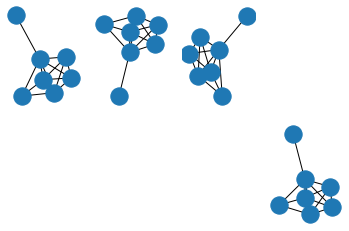

In [89]:

sub_graphs = list(nx.connected_components(G))
big_sub = [sub for sub in sub_graphs if len(sub) > 5]
print(big_sub[0])

sG = nx.subgraph(G, big_sub[0])
plt.subplot(241)
nx.draw_spring(sG)

plt.subplot(242)
nx.draw_spring(sG)

plt.subplot(243)
nx.draw_spring(sG)

plt.subplot(248)
nx.draw_spring(sG)

In [94]:
nx.spring_layout(sG)

{'GCF_000243695.2_gls454049v02|322176-323040': array([ 0.09909169, -0.18877041]),
 'GCF_000243735.2_gls454052v1.0|2330288-2331153': array([-0.54070555,  0.25553239]),
 'GCF_000243815.2_gls454062v02|14208-15072': array([-0.01303452,  0.16761801]),
 'GCF_000243715.2_gls454050v02|713356-714217': array([ 0.52535135, -1.        ]),
 'GCF_000244815.1_gls454188v02|48041-48905': array([-0.44525987, -0.11835559]),
 'GCF_000244755.1_ASM24475v3|1206309-1207168': array([0.49650945, 0.42105073]),
 'GCF_000306255.2_gls454059v02|64248-65114': array([-0.12195255,  0.46292486])}

In [ ]:
gridspec.GridSpec(3,3)
plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
nx.draw_spring(sG)
plt.subplot2grid((3,3), (0,2))

nx.draw_spring(sG)

In [96]:


import plotly.graph_objects as go